## Load necessary modules

In [23]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
import os
import numpy as np
import time
import csv
from PIL import Image
from natsort import natsorted

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

# paths and parameters
val_csv = 'C:\\Users\\jmj136.UWHIS\\Documents\\keras-retinanet\\keras_retinanet\\hcc_retinadata_val.csv'
model_path = os.path.join('C:\\Users','jmj136.UWHIS','Documents','keras-retinanet',
                          'keras_retinanet','snapshots', 'resnet50_csv_04.h5')
seq_list = ['Inp','Out','T2f','T1p','T1a','T1v','T1d','Dw1','Dw2']
seqs = seq_list[3:6]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load RetinaNet model

In [37]:
# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'lesion'}

## Load data to test

In [3]:
def load_image(image_path,seqs):
    image_paths = [image_path.format(s) for s in seqs]
    image_arrays = [np.asarray(Image.open(path).convert('L')) for path in image_paths]
    image = np.stack(image_arrays,axis=-1)
    image = np.flip(image,0)
    return image

In [35]:
with open(val_csv,'r') as f:
    reader = csv.reader(f,delimiter=',')
    data = [row for row in reader]
file_paths = [d[0] for d in data]
all_true_coords = [(int(d[1]), int(d[2]),int(d[3]),int(d[4])) for d in data]
unq_file_paths = natsorted(list(set(file_paths)))

## Run detection on example

processing time:  0.05314326286315918


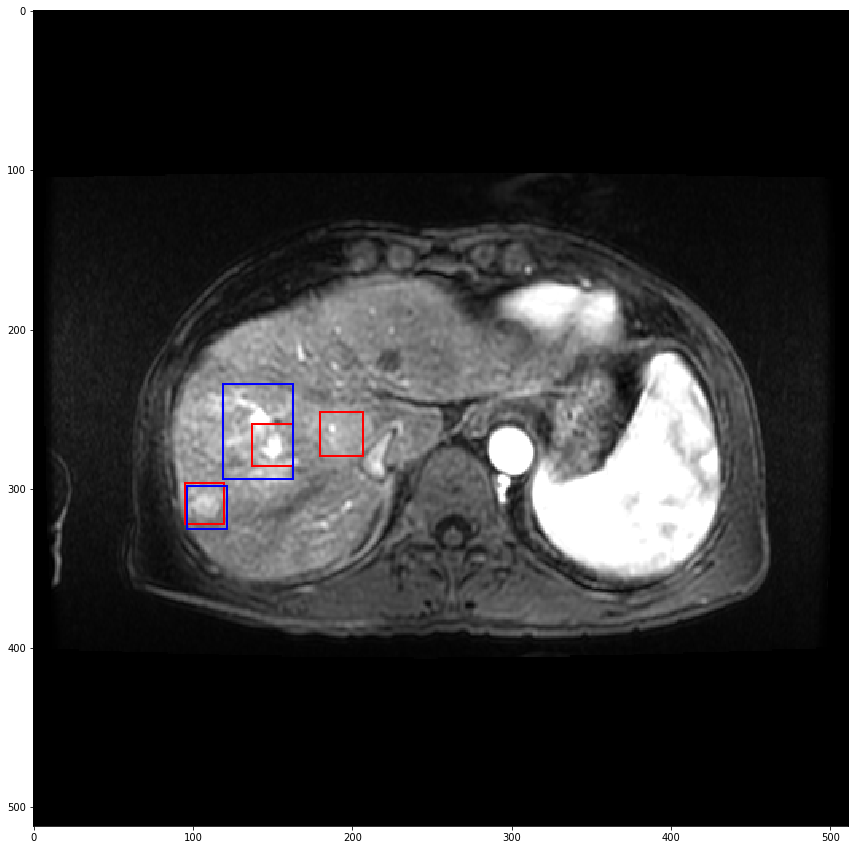

In [39]:
# load image
image_index = 8
image = load_image(unq_file_paths[image_index],seqs)
draw = np.copy(image)
draw = draw[...,1]
# draw = np.flip(draw,axis=0)

# preprocess
image = preprocess_image(image)
image,scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# Create figure and axes
_, ax = plt.subplots(1,figsize=(15,15))
# Display the image
ax.imshow(draw,cmap='gray')

# visualize detections
for coords, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < .4:
        break
    x = coords[0]
    y = coords[1]
    w = coords[2] - x
    h = coords[3] - y
    rect = patches.Rectangle(
        (x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

# get ground truth bboxes
bbox_inds = np.where([fp==unq_file_paths[image_index] for fp in file_paths])[0]
for bind in bbox_inds:
    coords = all_true_coords[bind]
    x = coords[0]
    y = coords[1]
    w = coords[2] - x
    h = coords[3] - y
    rect = patches.Rectangle(
        (x, y), w, h, linewidth=2, edgecolor='b', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()